# **Application of AIS Data for commodities tracking**

This project aims at investigating the quality and utility of Automatic Identification System (AIS) data. AIS data is primarily used as a tracking system for ships, but with the launch if satellites to collect this data new and previously untested posibilities are emerging.

 Initially AIS system was put in place as a safety measure by providing data to monitor ship traffic and avoid accidents, especially in highly trafficked waterways. But currently it can be efficiently used as a tool for for tracking commodities.

## **Project scope**

This project will be split in three different sections:
1. We'll get our hands on raw AIS data sample, decode it with AIS Parser SDK v1.10 and look into what parts of messages will be interesting for us to look into.
2. As the sample from AISHub is too small, we'll download dataset from Marine Cadastre which covers one time zone around Louisiana Offshore Oil Port (LOOP) for the period of January till June, 2015. Oil price was at its lowest point (47 dollars per barrel) in January, 2015 after crashing from 108 dollars per barrel mark in June 2014. Seasonality will also influence crude oil prices under normal supply and demand conditions. But compared to geopolitical tensions, oil glut, economic slowdown, or a financial crisis, the seasonality factor could have a minor effect. We'll work through the dataset, do a quick analysis and clean it, leaving only entries which have passed QC and are interesting for us. 
3. Lastly, we'll dive into GIS part (Geographic Information Systems) where we generate vessel routes and vessel position heatmaps if data consistency allows. Also we will look at major ports and nearby refineries of Texas and Lousiana. Main points of interest are LOOP with three single point mooring (SPM) buoys and port Houston. Final vizualization will be published online.

You can follow along by downloading data and AIS Parser SDK from the links below. We'll also use FME (very powerful spatial extract, transform and load tool) to transform Latitude/Longitude coordinates to geometry points, connect them to make routes and generate .shp files (native format for geospatial data). 

**Licenses:**

AIS Parser SDK is released under BSD license. FME is available as a trial version, but if you're a student you can get one year student license with one more year of extension. So FME is actually allowed for you to use at your new workspace after graduation. I honestly think it is great software and you definitely need to try it, because it is super powerful, has more than 400 transformers available, works with lots of data sources in read/write mode. And it's free! 

**Here are the links:**
*   AIS Parser SDK v1.10 - https://github.com/bcl/aisparser
*   Raw AIS Data Sample - https://mods.marin.nl/download/attachments/28770618/nmea-sample.zip?version=1&modificationDate=1497529053000&api=v2
*  US data split by UTM zones and years - https://marinecadastre.gov/ais/
*  FME - https://www.safe.com/fme/fme-desktop/trial-download/

if you are like me and heard about AIS two weeks ago, there are also countless articles and several studies online that will help and guide you. That's a very interesting topic with various business applications, so let's dive in.


## **AIS Data - General Overview**

AIS data can be provided by both satellites and land based receivers. Both methods provide raw data, then this data has to be decoded to get several messages .  To decode raw data we'll use AIS Parser SDK v1.10. After decoding, we can receive static and dynamic information.

**Dynamic information** is transmitted every 2 to 10 seconds depending on the vessel's speed and course while underway and every 6 minutes while anchored. It contains:


*  Maritime Mobile Service Identity number (MMSI) - a unique identification number for each vessel station
*  AIS Navigational Status
*  Rate of Turn - right or left (0 to 720 degrees per minute)
*  Speed over Ground - 0 to 102 knots (0.1-knot resolution)
*  Position Coordinates (latitude/longitude - up to 0.0001 minutes accuracy)
*  Course over Ground - up to 0.1° relative to true north
*  Heading - 0 to 359 degrees
*  Bearing at own position - 0 to 359 degrees
*  UTC seconds

**Static & Voyage related information** is provided by the subject vessel's crew and is transmitted every 6 minutes regardless of the vessel's movement status. This information is of great importance to us as it contains more metadata about vessel and journey itself:
* International Maritime Organisation number (IMO) - note that this number remains the same upon transfer of the subject vessel's registration to another country (flag)
* Call Sign - international radio call sign assigned to the vessel by her country of registry
* Name - up to 20 characters
* Type (or cargo type) - the AIS ID of the subject vessel's shiptype
* Dimensions - approximated to the nearest metre (based on the position of the AIS Station on the vessel)
* Location of the positioning system's antenna on board the vessel
* Type of positioning system (GPS, DGPS, Loran-C)
* Draught - 0.1 to 25.5 metres
* Destination - up to 20 characters
* ETA (estimated time of arrival) - UTC month/date hours:minutes

## Decoding Raw AIS Data

For this part of the project we will get our hands on AIS Raw data sample and AIS Parser SDK v1.10. You can download parser from GitHub link above. I didn't try to install it on Windows machine, but workaround on Mac is fairly easy. Firstly, download Homebrew for Mac. It is free software package management system for Mac. There are lots of packages available and with Homebrew it is really to install them. 

For our particular case we'll need to install 'Swig" (software tool that helps to wrap libraries written in C or C++ with scripting languages such as Lua, Perl, PHP, Python). With Homebrew it is as easy as typing "brew install swig" in your terminal. 

Then we'll download the git, go to the "aisparser/python/osx/buildit" folder and follow buildit instructions (simple as copy/pasting them line by line to your terminal). The only thing you'll need to check in here is which Python Framework you want to install this package to, it can be changed in command:

PYTHON_INCLUDE=/System/Library/Frameworks/Python.framework/Versions/2.3/include/python2.3/

Include your directory after "PYTHON_INCLUDE="". Now we are all set and could use AIS Parser just by typing "import aisparser" ito our python script.

### Runme.py

Below is the block of script to decode sample data. We only inlcude part for one message (message #5) to give idea of how parser works. We can access all bits of information from other messages in a similar way.

In [0]:
# Import aisparser library.
import aisparser
#Open Raw data sample file and append each line into a list.
fhand = open('nmea-sample.txt', 'r')
s = list()
for line in fhand:
    s.append(line.rstrip())

ais_state = aisparser.ais_state()
#Read eachi line in created list and parse it into messages.
for p in s:
    result = aisparser.assemble_vdm(ais_state, p)
    if (result == 0):
        ais_state.msgid = aisparser.get_6bit(ais_state.six_state, 6)
#Message 5 can provide us information about vessel and journey.
        if ais_state.msgid == 5:
            msg = aisparser.aismsg_5()
            aisparser.parse_ais_5(ais_state, msg)

            print("mmsi       : %d" % (msg.userid))
            print("name       : %s" % (msg.name))
            print("imo        : %s" % (msg.imo))
            print("callsign   : %s" % (msg.callsign))
            print("vesseltype : %s" % (msg.ship_type))
            print("length     : %s" % (msg.dim_port))
            print("width      : %s" % (msg.dim_starboard))
            print("draught    : %s" % (msg.draught))
            print("destination: %s" % (msg.dest))
            

### Aisparser.py

If we will look at aisparser.py script included in the git, we can see what parts of message we can retrieve. Below is the part of the class for message #3, which is message holding information about vessel position. Please note that it's onlt the part of the code, full script you can find under aisparser.py from git.

In [0]:
class aismsg_3(_object):
    __swig_setmethods__ = {}
    __setattr__ = lambda self, name, value: _swig_setattr(self, aismsg_3, name, value)
    __swig_getmethods__ = {}
    __getattr__ = lambda self, name: _swig_getattr(self, aismsg_3, name)
    __repr__ = _swig_repr
    __swig_setmethods__["msgid"] = _aisparser.aismsg_3_msgid_set
    __swig_getmethods__["msgid"] = _aisparser.aismsg_3_msgid_get
    if _newclass:msgid = _swig_property(_aisparser.aismsg_3_msgid_get, _aisparser.aismsg_3_msgid_set)
    __swig_setmethods__["repeat"] = _aisparser.aismsg_3_repeat_set
    __swig_getmethods__["repeat"] = _aisparser.aismsg_3_repeat_get
    if _newclass:repeat = _swig_property(_aisparser.aismsg_3_repeat_get, _aisparser.aismsg_3_repeat_set)
      #Userid is MMSI code.
    __swig_setmethods__["userid"] = _aisparser.aismsg_3_userid_set
    __swig_getmethods__["userid"] = _aisparser.aismsg_3_userid_get
    if _newclass:userid = _swig_property(_aisparser.aismsg_3_userid_get, _aisparser.aismsg_3_userid_set)
      #Navigation status - under way using engine, moored, etc.
    __swig_setmethods__["nav_status"] = _aisparser.aismsg_3_nav_status_set
    __swig_getmethods__["nav_status"] = _aisparser.aismsg_3_nav_status_get
    if _newclass:nav_status = _swig_property(_aisparser.aismsg_3_nav_status_get, _aisparser.aismsg_3_nav_status_set)
      #Sog - speed over the ground
    __swig_setmethods__["sog"] = _aisparser.aismsg_3_sog_set
    __swig_getmethods__["sog"] = _aisparser.aismsg_3_sog_get
    if _newclass:sog = _swig_property(_aisparser.aismsg_3_sog_get, _aisparser.aismsg_3_sog_set)
      #Coordinates
    __swig_setmethods__["longitude"] = _aisparser.aismsg_3_longitude_set
    __swig_getmethods__["longitude"] = _aisparser.aismsg_3_longitude_get
    if _newclass:longitude = _swig_property(_aisparser.aismsg_3_longitude_get, _aisparser.aismsg_3_longitude_set)
    __swig_setmethods__["latitude"] = _aisparser.aismsg_3_latitude_set
    __swig_getmethods__["latitude"] = _aisparser.aismsg_3_latitude_get


Using AIS Parser SDK we can come up with a .csv format that is used by Marine Cadastre to create a dataset, which we will use in the next section. 

## Marine Cadastre Dataset

Now we'll load data from MarineCadastre and perform quick analysis. This data is from one parcitucal zone - UTM Zone 15 for the period from January till December 2015. UTM Zone 15 is of particular interest as it covers Texas area and LOOP (The Louisiana Offshore Oil Port). 

From WikiPedia: "LOOP is a deepwater port in the Gulf of Mexico 29 kilometers (18 nautical miles) off the coast of Louisiana near the town of Port Fourchon. LOOP provides tanker offloading and temporary storage services for crude oil transported on some of the largest tankers in the world. Most tankers offloading at LOOP are too large for U.S. inland ports. LOOP handles 13 percent of the nation's foreign oil, about 1.2 million barrels (190,000 m3) a day, and connects by pipeline to 50 percent of the U.S. refining capability." 

If we want to see how oil crisis affected transport of commodities, that's the place of interest.

We'll use this particular dataset for two reasons:
* Dataset for 2015 contains more information that might be useful to us. For all previous years ship name, call sign fields have been removed, and the MMSI (Maritime Mobile Service Identity) field has been encrypted at the request of the U.S. Coast Guard.
* Beginning of the 2015 year was a critical point for oil and gas industry with oil prices reaching lowest point, dropping from 108 dollars per barrel at June, 2014 to 47 dollars per barrel in January, 2015. We will see if we can catch this change in oil and gas marker in our observations.



### Create SQLite DB

As Marine Cadastre dataset is a huge .csv file (about 9 Gb for one month of data), we'll load it to SQLite database, then we can easlity work with this data without running out of memory issues. Code below creates simple SQLite DB. 

In [0]:
import sqlite3

def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
    except:
        print('Error')
    finally:
        conn.close()

if __name__ == '__main__':
    create_connection('/Users/bobonaleksei/Downloads/AIS Project/AIS.db')

### Load CVS to SQLite

Then we will load .csv file to newly created DB, using chunks option within pandas framework to load .csv piece by piece.

In [0]:
import pandas as pd
from sqlalchemy import create_engine
filename = '/Users/bobonaleksei/Downloads/AIS Project/AIS_ASCII_by_UTM_Month/2015/AIS_2015_01_Zone15.csv'
#Display first five rows of csv file.
print(pd.read_csv(filename, nrows=5))
#Create a database engine using sqlalchemy (basically connection to DB).
csv_database = create_engine('sqlite:////Users/bobonaleksei/Downloads/AIS Project/AIS.db')
#Select chunksize which will be sufficient enough but won't run you out of memory.
chunksize = 100000
#Simple iterators to create with indexes
i = 0
j = 1
for df in pd.read_csv(filename, chunksize=chunksize, iterator=True):
  #We will need to remove all the spaces from column names, before creating a table in DB.
    df = df.rename(columns={c: c.replace(' ', '') for c in df.columns})
    df.index += j
    i += 1
    #Creates new table and appends data to it.
    df.to_sql('UTM15_01_2015', csv_database, if_exists='append')
    #Uses last index of the dataframe and adds 1 to start with a new chunk of data. 
    j = df.index[-1] + 1

### Query tanker related data from DB and write it to CSV.

After we loaded everything in SQLite, we can query it to extract only rows which have tanker "VesselType" - that are coded values in range from 80 to 89. 

In [0]:
import pandas as pd
from sqlalchemy import create_engine
#Use asqalchemy engine to create a connection
csv_db = create_engine('sqlite:////Users/bobonaleksei/Downloads/AIS Project/AIS.db')
#Query table to extract all rows with VesselType in range from 80-89.
query = 'SELECT * FROM UTM15_01_2015 WHERE VesselType IN ("80.0","81.0","82.0","83.0","84.0","85.0","86.0","87.0","88.0","89.0")'
#Pass the query result to dataframe
df = pd.read_sql_query(query,csv_db)
#Write dataframe to .csv file
df.to_csv('/Users/bobonaleksei/Downloads/AIS Project/2015_cargo_all.csv', sep='\t')

### Tanker data - Quick look

Now that we have just part of the whole dataset covering only tankers within our zone of interest, we can start with quick data analysis.

What we'll need is to import necessary libraries:
* Pandas - to work with nicely formated tabular data 
* Numpy - to work with arrays
* Matplotlib / seaborn - to create plots and vizualize data



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Jupyter notebook magic command, it allows us to generate plots directly within this notebook. 

In [2]:
%matplotlib inline

Load .csv file to "tanker_data" DataFrame. We'll use tab separator to split data into columns.

In [3]:
tanker_data = pd.read_csv('/Users/bobonaleksei/PycharmProjects/AIS/2015_01_tanker_static.csv', sep='\t')

Let's have a look how many rows and columns we have in our dataframe.

In [4]:
tanker_data.shape

(334022, 18)

Display first 5 rows, which include our header.

In [5]:
tanker_data.head()

,Unnamed: 0,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,0,116,636013447,2015-01-01T00:00:52,28.55866,-94.25811,0.1,-110.6,63.0,MANIFA,IMO9384198,A8NA7,89.0,at anchor,333.0,60.0,11.4,89.0
1,1,180,311047100,2015-01-01T00:01:07,29.70042,-95.00295,11.1,-129.6,276.0,NORDIC AKI,IMO9505974,C6YV9,89.0,under way using engine,134.0,22.0,7.3,89.0
2,2,687,375439000,2015-01-01T00:00:13,29.17793,-94.65495,0.1,99.0,60.0,MAPLE 3,IMO9034690,J8B3453,84.0,at anchor,160.0,26.0,9.3,84.0
3,3,692,229837000,2015-01-01T00:00:06,29.60868,-93.80883,8.9,-74.4,339.0,SYN ANTARES,IMO9512848,9HA3650,80.0,under way using engine,123.0,19.0,5.6,80.0
4,4,901,565721000,2015-01-01T00:02:03,29.73733,-95.12913,0.0,147.0,183.0,MT CHEMBULK ULSAN,IMO9294276,9VFA4,80.0,moored,141.0,24.0,10.3,80.0


"Unnamed" column holds an index that is of no interest to us, let's drop this column. "Axis=1" specifies that "Unnamed" is a column and not a row, while "inplace=True" lets us to make changes in existing dataframe without creating a copy. 

In [6]:
tanker_data.drop('Unnamed: 0', axis=1, inplace=True)

### Change column datatypes

Below is the list of our colums with their corresponding datatypes. We can see that BaseDateTime is an object, to work properly with dates we need to convert it to date type. Cargo and Vessel type are floats, we can covert them to integers. 

The most important column to convert is IMO. Values in this column starts with three letters 'IMO' followed by 7 digits assigned to sea-going merchant ships under the International Convention for the Safety of Life at Sea (SOLAS). For ships, the IMO number remains linked to the hull for its lifetime, regardless of a change in name, flag, or owner. Therefore knowing the IMO, we can surely identify the vessel.

The validity of IMO numbers can be verified by its check digit. This is done by multiplying each digit with its position from right to left, with exception from its first rightmost digit. This is called the check digit. The results of these multiplications shall be summed, and the last digit in that sum shall correspond to the check digit in the IMO number. So for the IMO number 9652806, 9x7+6x6+5x5+2x4+8x3+0x2 = 156, the rightmost digit of this sum is equal to the rightmost digit of the IMO number, and thus the IMO number is valid.

So to perform the validation check on IMO number we need to get rid of "IMO" letters and convert the rest to interger type. Trying to perfrom any calculus on object type will give us traceback.

In [7]:
tanker_data.dtypes

index             int64
MMSI              int64
BaseDateTime     object
LAT             float64
LON             float64
SOG             float64
COG             float64
Heading         float64
VesselName       object
IMO              object
CallSign         object
VesselType      float64
Status           object
Length          float64
Width           float64
Draft           float64
Cargo           float64
dtype: object

Change BaseDateTime to data type.

In [8]:
tanker_data['BaseDateTime'] = pd.to_datetime(tanker_data['BaseDateTime'])

Change Cargo and VesselType to integer

In [9]:
tanker_data['VesselType'] = tanker_data['VesselType'].astype(int)

In [10]:
tanker_data['Cargo'] = tanker_data['Cargo'].astype(int)

Apply method for pandas is very powerful thing. You can use your own functions and apply them to whole column (which are called Series in pandas). We'll use "apply" to slice every value and leave only last 7 digits. So IMO9652806 will give us only 9652806, on which we can perfom math operation after converting it to integer.

In [11]:
tanker_data['IMO'] = tanker_data['IMO'].apply(lambda x: x[3:])
tanker_data['IMO'] = tanker_data['IMO'].astype(int)

Check if conversion worked, all good.

In [12]:
tanker_data.dtypes

index                    int64
MMSI                     int64
BaseDateTime    datetime64[ns]
LAT                    float64
LON                    float64
SOG                    float64
COG                    float64
Heading                float64
VesselName              object
IMO                      int64
CallSign                object
VesselType               int64
Status                  object
Length                 float64
Width                  float64
Draft                  float64
Cargo                    int64
dtype: object

### Unique and Null values

Value_counts gives us idea how many distinct values we have in "VesselType" column. 84 is interesting code for us, as it stands for LNG tanker, LPG tanker or Gas carrier.

In [13]:
tanker_data['VesselType'].value_counts()

80    144475
89     99222
82     37268
81     33249
84     15340
86      4468
Name: VesselType, dtype: int64

We will also check if any of the values are Null per column. We are lucky to have this dataset from Marine Cadastre as data was enriched already and there is no null values.

In [14]:
tanker_data.isnull().any()

index           False
MMSI            False
BaseDateTime    False
LAT             False
LON             False
SOG             False
COG             False
Heading         False
VesselName      False
IMO             False
CallSign        False
VesselType      False
Status          False
Length          False
Width           False
Draft           False
Cargo           False
dtype: bool

Check number of unique values in MMSI, VesselName and IMO columns. As we're looking at data from just one year, it would be logical to see that one IMO corresponds to one MMSI and one VesselName. Below is just a count, we'll have a proper check of corresponding values later.

In [15]:
tanker_data.MMSI.nunique()

80

In [16]:
tanker_data.VesselName.nunique()

80

In [17]:
tanker_data.IMO.nunique()

80

### Erroneous vessel dimensions

Let's create a scatter plot with Length on x axis and Breath on y axis. As we can see from the scatter plot below there are some points on far left and far right side on the Vessel Length axis. The rest of the vessels are grouped close to each other with clear difference between two classes. 
Based on VesselTracker vessels on the left of 200m length mark belong to "Chemical Oil Products Tanker", so that tankers possibly transport by products of oil. Vessels above 200m in length belong to 'Crude Oil Tanker' with particular group at 330m in length - which belong to VLCC.

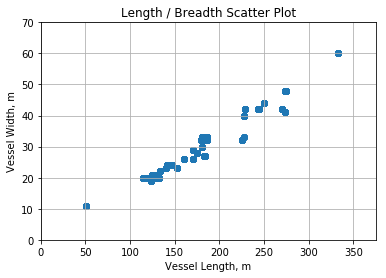

In [18]:
plt.scatter(tanker_data['Length'], tanker_data['Width'], data=tanker_data['VesselType'])
plt.ylabel('Vessel Width, m')
plt.xlabel('Vessel Length, m')
plt.xlim((0,375))
plt.ylim((0,70))
plt.title('Length / Breadth Scatter Plot')
plt.grid(True)

From scatter plot we can see that there is an outlier(vessel with Width below 15m). Below is a corresponding part of dataframe for this vessel. After manual lookup at VesselTracker.com, we can identify vessel "Roma Elie" as an Offshore Tug Supply Ship. Wrong VesselType was probably entered by the crew. 

In [19]:
tanker_data[tanker_data['Width']<15].head()

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
149517,4976945523,368651926,2015-01-15 10:43:49,28.99371,-90.01105,10.8,-130.7,511.0,ROMA^ ELIE,10036466,WDH3006,86,under way using engine,51.0,11.0,0.0,86
149529,4976948370,368651926,2015-01-15 10:45:49,28.99486,-90.01789,10.9,-129.9,511.0,ROMA^ ELIE,10036466,WDH3006,86,under way using engine,51.0,11.0,0.0,86
149542,4976950518,368651926,2015-01-15 10:47:19,28.99567,-90.02298,10.7,-127.9,511.0,ROMA^ ELIE,10036466,WDH3006,86,under way using engine,51.0,11.0,0.0,86
149561,4976954864,368651926,2015-01-15 10:50:49,28.99811,-90.03460,10.9,-123.6,511.0,ROMA^ ELIE,10036466,WDH3006,86,under way using engine,51.0,11.0,0.0,86
149562,4976954943,368651926,2015-01-15 10:54:19,29.00145,-90.04580,10.4,-118.8,511.0,ROMA^ ELIE,10036466,WDH3006,86,under way using engine,51.0,11.0,0.0,86


In [20]:
tanker_data[tanker_data['Length']<200].head()

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
1,180,311047100,2015-01-01 00:01:07,29.70042,-95.00295,11.1,-129.6,276.0,NORDIC AKI,9505974,C6YV9,89,under way using engine,134.0,22.0,7.3,89
2,687,375439000,2015-01-01 00:00:13,29.17793,-94.65495,0.1,99.0,60.0,MAPLE 3,9034690,J8B3453,84,at anchor,160.0,26.0,9.3,84
3,692,229837000,2015-01-01 00:00:06,29.60868,-93.80883,8.9,-74.4,339.0,SYN ANTARES,9512848,9HA3650,80,under way using engine,123.0,19.0,5.6,80
4,901,565721000,2015-01-01 00:02:03,29.73733,-95.12913,0.0,147.0,183.0,MT CHEMBULK ULSAN,9294276,9VFA4,80,moored,141.0,24.0,10.3,80
5,914,311047100,2015-01-01 00:02:18,29.70080,-95.00713,11.2,-134.6,275.0,NORDIC AKI,9505974,C6YV9,89,under way using engine,134.0,22.0,7.3,89


In [21]:
tanker_data[tanker_data['Length']>200].head()

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,116,636013447,2015-01-01 00:00:52,28.55866,-94.25811,0.1,-110.6,63.0,MANIFA,9384198,A8NA7,89,at anchor,333.0,60.0,11.4,89
7,1030,538004568,2015-01-01 00:00:20,28.58218,-94.58314,0.0,-87.8,54.0,SAMCO TAIGA,9590888,V7XT7,89,at anchor,333.0,60.0,10.7,89
11,2292,241345000,2015-01-01 00:01:42,29.18032,-94.58893,0.1,106.7,57.0,OLYMPIC SEA,9489285,SVCB4,80,at anchor,244.0,42.0,9.0,80
19,4716,240613000,2015-01-01 00:01:39,29.13163,-94.57624,0.1,-121.6,49.0,CARMEL,9308857,SZQG,89,at anchor,244.0,42.0,11.0,89
27,6085,538004568,2015-01-01 00:06:18,28.58258,-94.58348,0.2,-88.4,71.0,SAMCO TAIGA,9590888,V7XT7,89,at anchor,333.0,60.0,10.7,89


Let's get all the IMOs for vessels whose length is above 300m. As we will see they belong to Very Large Crude Carriers (VLCC).

In [22]:
tanker_data[tanker_data['Length']>300].IMO.unique()

array([9384198, 9590888, 9484730, 9384215, 9519494])

### Erroneous IMO

Below is a simple function to check the IMO validity (idea behind the validity check was explained above).

In [23]:
def IMO_validity(IMO):
    sn = [int(d) for d in str(IMO)]
    checksum = sn[0]*7 + sn[1]*6 + sn[2]*5 + sn[3]*4 + sn[4]*3 + sn[5]*2
    checksum_split = [int(d) for d in str(checksum)]
    if checksum_split[-1] == sn[6]:
        return True
    else:
        return False

Check single IMO example.

In [24]:
IMO_validity(9412036)

True

Create new column "IMO_Valid" and populate it with True/False by applying newly created IMO_Validity function.

In [25]:
tanker_data['IMO_Valid'] = tanker_data['IMO'].apply(IMO_validity)

We've got almost 26,000 rows with invalid IMO.

In [26]:
tanker_data['IMO_Valid'].value_counts()

True     308103
False     25919
Name: IMO_Valid, dtype: int64

Let's check how many vessels actually have invalid IMO.

In [27]:
tanker_data['VesselName'][tanker_data['IMO_Valid']==False].unique()

array(['EAGLE SYDNEY', 'ROMA^ ELIE'], dtype=object)

EAGLE SYDNEY has IMO 9371651, there are 6 different vessels with same IMO on VesselTracker website, all of them have different length.

In [28]:
tanker_data[tanker_data['VesselName']=='EAGLE SYDNEY'].head()

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,IMO_Valid
424,78384,352124930,2015-01-01 00:19:27,28.28015,-90.76265,0.0,-99.6,71.0,EAGLE SYDNEY,9371651,3FUU,81,restricted maneuverability,229.0,42.0,10.5,81,False
427,78509,352124930,2015-01-01 00:12:48,28.28007,-90.76252,0.1,-100.6,70.0,EAGLE SYDNEY,9371651,3FUU,81,restricted maneuverability,229.0,42.0,10.5,81,False
434,79716,352124930,2015-01-01 00:00:08,28.28008,-90.76253,0.1,114.0,72.0,EAGLE SYDNEY,9371651,3FUU,81,restricted maneuverability,229.0,42.0,10.5,81,False
435,79723,352124930,2015-01-01 00:18:08,28.28017,-90.76263,0.1,-99.6,71.0,EAGLE SYDNEY,9371651,3FUU,81,restricted maneuverability,229.0,42.0,10.5,81,False
445,82440,352124930,2015-01-01 00:39:47,28.28015,-90.76267,0.0,164.0,69.0,EAGLE SYDNEY,9371651,3FUU,81,restricted maneuverability,229.0,42.0,10.5,81,False


Second vessel we have seen before, that's our offshore tug vessel with wrong VesselType.

Later we will drop all rows for two vessels - Eagle Sydney (invalid IMO) and Roma Elie (does not belong to tanker class of vessels).  

### Erroneous vessel coordinates

Let's check erroneous vessel position by plotting latitude/longitude coordinates for all entries and look for outliers.

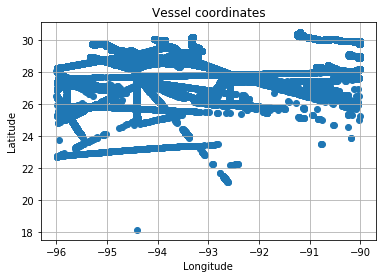

In [30]:
plt.scatter(tanker_data.LON,tanker_data.LAT)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vessel coordinates')
plt.grid(True)

Some values lay below 20 deg of Latitude. DataFrame slice is below.

In [31]:
tanker_data[tanker_data['LAT']<20]

,index,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,IMO_Valid
277935,16675239660,538005660,2015-01-28 06:52:16,18.12807,-94.40351,0.5,-160.2,32.0,TORM GUNHILD,9172193,V7FU7,89,under way using engine,180.0,32.0,11.0,89,True


As we can see from the slice, it's a single point from "Torm Gunhild" vessel. Let's plot whole route for this vessel.

In [32]:
torm = tanker_data[tanker_data['IMO']==9172193]

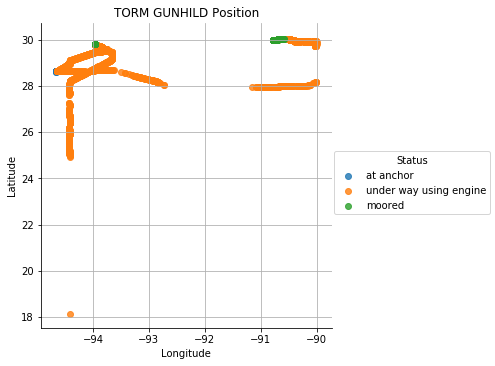

In [34]:
sns.lmplot(x='LON',y='LAT', data=torm, fit_reg=False, hue='Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('TORM GUNHILD Position')
plt.grid(True)

There's one definite outlier in vessel position, we can remove right before generating routes with FME.

### Erroneous MMSI

Block below checks if there's any MMSI number which have more than one corresponding IMO number. In our case there is no discrepancy, partially due to dataset representing only one month timeframe. 

In [35]:
for x in np.nditer(tanker_data['MMSI'].unique()):
    if len(tanker_data[tanker_data['MMSI']==int(x)]['IMO'].unique()) ==1:
        continue
    else:
        print('MMSI {} does not have unique IMO'.format(x))


### Final preparations

Now we can remove all the erroneous data before exporting LAT/LON points vessel by vessel and prepare clean dataframe for January 2015. As mentioned before, we'll need to drop all rows corresponding to two vessels - Eagle Sydney (invalid IMO) and Roma Elie (does not belong to tanker class of vessels). 

In [36]:
clean_tanker_data = tanker_data[(tanker_data['IMO'] != 9371651) & (tanker_data['IMO'] != 10036466)]

Check that remaining records have valid IMO.

In [37]:
clean_tanker_data.IMO_Valid.value_counts()

True    308103
Name: IMO_Valid, dtype: int64

Let's create separate csv file for each vessel within dataframe. We will need that to create points to load in GIS (Geographic Information Systems) and later generate vessel routes from this points. 

In [0]:
for x in np.nditer(clean_tanker_data['MMSI'].unique()):
    clean_tanker_data[clean_tanker_data['MMSI'] == int(np.array_str(x))].to_csv('{} Position.csv'.format(x), sep='\t')

We will also create cleaned version of csv file for January, 2015.

In [0]:
clean_tanker_data.to_csv('tanker_data_01_cleaned.csv', sep='\t')

That was quick analysis of AIS Marine Cadastre dataset covering January, 2015. To create final vizualization, we will follow steps mentioned above for all period of project - January till March for 2014 and 2015. After we have all csv files with coordinates per vessel per month, we can create vessel routes and generate heat maps, which will give us idea, where vessel loaded and offloaded and look at correlation with change of vessel status ("under way using engine", change to "moored" )

## Create and map vessels' routes

In this section we will look into Geographic Information Systems (GIS) workflow. GIS provides us a great way to vizualize your data, make quick spatial queries and share your findings with maps. There are several systems available on the market, most famous are ArcGIS (proprietary) and QGIS (open-source). To vizualize vessel routes we'll use QGIS 3, as well as FME (spatial extract, transform, load tool) to prepare our data.

What we have right now is a subset of data per vessel per month with latitude/longitude coordinates in a .csv format. To work with them in QGIS we need to convert it to .shp files. SHP files can store geometry (point, line, polygon, multiline, etc.) and attributes in it (think of a normal table). 

To transform existing data we'll use FME. Below is a snapshot of FME workbench. It has reader, write and 5 transformers:
* Reader - CSVReader, reads csv file by specifying delimiter. Also assigns CRS at this step - WGS84.
* VertexCreator - takes LON/LAT values and creates a point geometry;
* Sorter - sorts all points per date, starting from oldest to newest;
* PointConnector - connects points one by one in order of occurance, that's why we need a Sorter first. Otherwise it will connect points in wrong order;
* AttributeCreator_2 - fix BaseDateTime to date type;
* FeatureHolder - holds all the features before writing them in a batch to .shp file;
* Writer - writes features to .shp file with predefined fields, because we won't need all the fields for our routes (ex. SOG, COG, heading).


![title](/Users/bobonaleksei/PycharmProjects/AIS/FME Workbench/FME.png)

After we've got .shp file with route per vessel per month, we can merge all routes per month in one shapefile and add it to the map. Map can be accessed from the link below:


### Findings got from visualizing our dataset:

1) Positional data has lots of missing values, plotting points over the line will show you the existing gap.

https://s3.eu-west-3.amazonaws.com/aisprojectforkpler/Positional+data+-+missing+values/1.+Positional+data+-+missing+values.html

2) Some of the vessel can access ports that are deep inland. Based on their Length/Width we can predict the berth that will be capable of accepting them.

https://s3.eu-west-3.amazonaws.com/aisprojectforkpler/Length%3AWidth+for+Destination+prediction/2.+Length%3AWidth+for+destination+prediction.html

3) Found certain "circular patterns" on the map. One of the patterns exists when vessel is "at anchor", it belongs only to one vessel and apply to only one position. Second circular pattern is actually very interesting for us. It is SPM (Single Point Mooring buoy) of LOOP, it allows to offload VLCCs and ULCCs which are too big to enter the port. Hi-tech, flexible hoses are attached to the ship's manifold to receive and transport the crude oil. The buoy and hoses can rotate a full 360 degrees allowing the tanker to maintain a heading of least resistance to wind and waves. Therefore we can see circular patterns here. But in this case there exist more than one route exists, providing us information about operational nature of this pattern.

Last pattern can be used as a trigger for offloading event manager.

https://s3.eu-west-3.amazonaws.com/aisprojectforkpler/Circular+references/3.+Circular+references.html

4) We split vessels into two major groups - first one is tankers that transport oil products and chemicals with length less than 200m and crude oil tankers - above 200m with separate category of VLCCs (about 330m). We can see that amount of vessels of this group decreased from 20 vessels per month in January to 14 vessels per month in June. Also there's not much activity at SPMs, major of the traffic is distributed to inland ports.

https://s3.eu-west-3.amazonaws.com/aisprojectforkpler/VLCCs/4.+VLCCs.html

https://s3.eu-west-3.amazonaws.com/aisprojectforkpler/Vessel+Traffic+Q1Q2+2015/5.+Vessel+Traffic+Q1Q2+2015.html

## Conclusion

With more finely grained AIS data becoming available due to the reduction in decimation and with AIS data being integrated with a wide range of IoT sensors in ports, on ships and fitted to cargo, weather data, radar data and data from other geospatial and imaging sensors, the volume and breadth of data to be collected, pro- cessed stored, analysed and reported on is growing and creating new insights into the maritime environment resulting in new commercial opportunities.

These new commercial opportunities include:
1. Streaming analytics to clean AIS data providing real time insight into vessel activities with complex events adding new data and new insights
2. Historical analytics allow the development of contextual models and patterns to provide insight and support the streaming analytics and allows the development of prescriptive analytics applications
3. Detection of complex events adding data and information available to support the maritime operator environment
4. The integration of IoT sensors on the ship and shore will support the improvement in efficiencies and lead to further gains in safety, security and improve the economic viability and the environmental protection in this domain

As we could see, AIS data can be erroneous and has to be treated carefully. But once this is done, you can have a valuable source of information for tracking commodities with value added event manager and route prediction.